In [2]:
# Manipulación de datos
# ==============================================================================
import numpy as np
import pandas as pd

# Visualización de datos
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import pylab

# Modelado
# ==============================================================================
import scipy.stats as stats
from sklearn.feature_selection import mutual_info_regression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix


# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [3]:
# colore settings:
sns.set(rc={'axes.facecolor':"#EAEDED",
            "figure.facecolor":"#AED6F1",
            "grid.color":"#E0D3AF",
            "axes.edgecolor":"#424949",
            "axes.labelcolor":"#424949",
            "text.color":"#424949" # color for headlines and sub headlines
           })

In [4]:
url_train = "https://github.com/PabloJRW/titanic-classifier/raw/main/train.csv"
url_test = "https://github.com/PabloJRW/titanic-classifier/raw/main/test.csv"
df_train = pd.read_csv(url_train)
df_test = pd.read_csv(url_test)

# <b>EDA (Análisis Exploratorio de Datos) 

In [5]:
df_train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
# Eliminción de variables irrelevantes
df_train.drop(['Name'], axis=1, inplace=True)
df_test.drop(['Name'], axis=1, inplace=True)
# Renombrado de variables en datos de entrenamiento
df_train.columns = ["id", "vida", "clase", "sexo", "edad", "sibsp", "parch", "ticket", "tarifa", "cabina", "puerto"]
# Renombrado de variables en datos de prueba
df_test.columns = ["id", "clase", "sexo", "edad", "sibsp", "parch", "ticket", "tarifa", "cabina", "puerto"]

In [7]:
# Tipo de cada columna
# ==============================================================================
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      891 non-null    int64  
 1   vida    891 non-null    int64  
 2   clase   891 non-null    int64  
 3   sexo    891 non-null    object 
 4   edad    714 non-null    float64
 5   sibsp   891 non-null    int64  
 6   parch   891 non-null    int64  
 7   ticket  891 non-null    object 
 8   tarifa  891 non-null    float64
 9   cabina  204 non-null    object 
 10  puerto  889 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 76.7+ KB


In [8]:
# Dimensiones del dataset de entrenamiento
# ==============================================================================
df_train.shape

(891, 11)

In [9]:
# Número de datos ausentes por variable en datos de entrenamiento
# ==============================================================================
df_train.isna().sum().sort_values(ascending=False)

cabina    687
edad      177
puerto      2
id          0
vida        0
clase       0
sexo        0
sibsp       0
parch       0
ticket      0
tarifa      0
dtype: int64

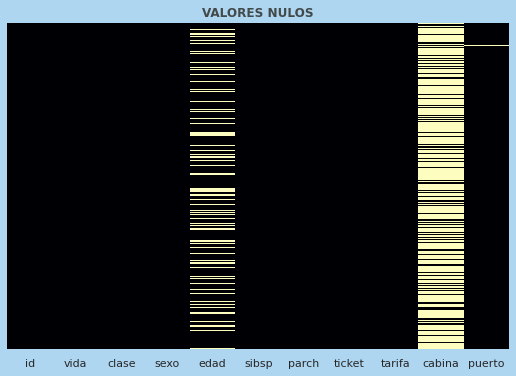

In [10]:
# Visualización de variables con valores faltantes
plt.figure(figsize=(9,6))
plt.title('VALORES NULOS', fontweight='bold')
sns.heatmap(df_train.isnull(), yticklabels=False, cbar=False, cmap='magma')
plt.show()

In [11]:
# La variable cabina contiene gran cantidad de valores faltantes por lo que la elimino.
df_train.drop('cabina', axis=1, inplace=True)
df_test.drop('cabina', axis=1, inplace=True)

# Copia de los datasets
train = df_train.copy()
test = df_test.copy()

### <b>Mutual Information

In [12]:
X = train.drop('id', axis=1)
X = X.dropna()
y = X.pop('vida')

# Label encoding for categoricals
for colname in train.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

# All discrete features should now have integer dtypes (double-check this before using MI!)
discrete_features = X.dtypes == int

In [13]:
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores  # show a few features with their MI scores

ticket    1.410423
sexo      0.142660
tarifa    0.139388
clase     0.058367
sibsp     0.034831
edad      0.006947
puerto    0.002861
parch     0.000000
Name: MI Scores, dtype: float64

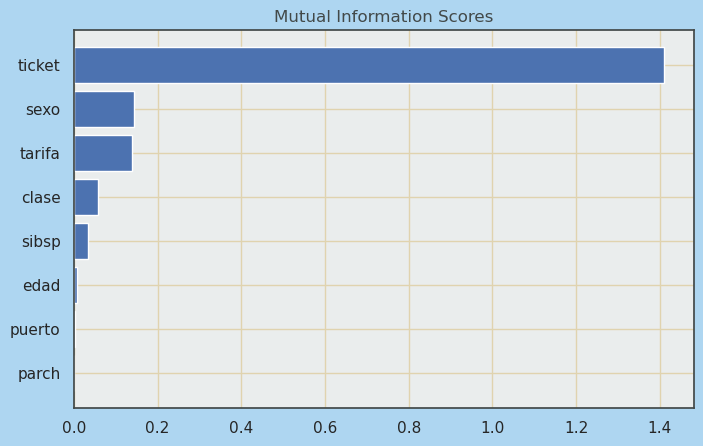

In [14]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

## <b>Variable Respuesta 

La variable respuesta para el modelo a desarrollar es <b>'vida'</b>, la cual nos indica si un pasajero sobrevivió o no
al hundimiento del Titanic. <b>0</b> = Falleció, <b>1</b> = Sobrevivió.

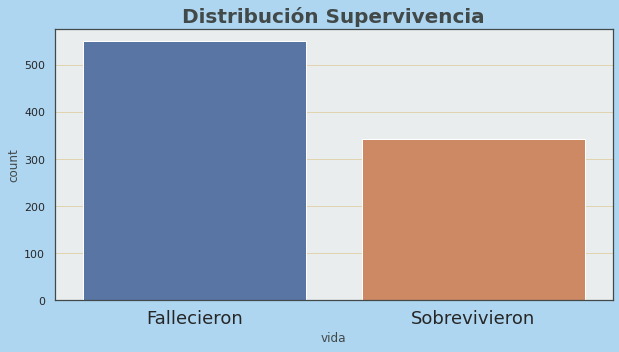

In [15]:
# Distribución de la variable objetivo
fig, ax = plt.subplots(figsize=(10, 5))
plt.title('Distribución Supervivencia', fontweight='bold', fontsize=20)
sns.countplot(x=train['vida'], ax=ax)
ax.set_xticklabels(('Fallecieron', 'Sobrevivieron'), fontsize=18)
plt.show()

In [16]:
# Cuál fue el porcentaje de sobrevivientes?
print(f"Porcentaje de supervivientes: {round(len(train[train['vida']==1]) / len(train) * 100, 1) }%")

Porcentaje de supervivientes: 38.4%


<b>📝 Note:</b> El 38.4% de los pasajeros que viajaron abordo del Titanic sobrevivieron, en contraparte, falleció el 61.6%.

## <b>VARIABLES NUMÉRICAS

## *****************************************************************************

In [18]:
# Copia de los datasets
train = train.copy()
test = test.copy()

In [19]:
# Variables numéricas
# ==============================================================================
train.select_dtypes(include=["float64", "int"]).describe()

,id,vida,clase,edad,sibsp,parch,tarifa
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


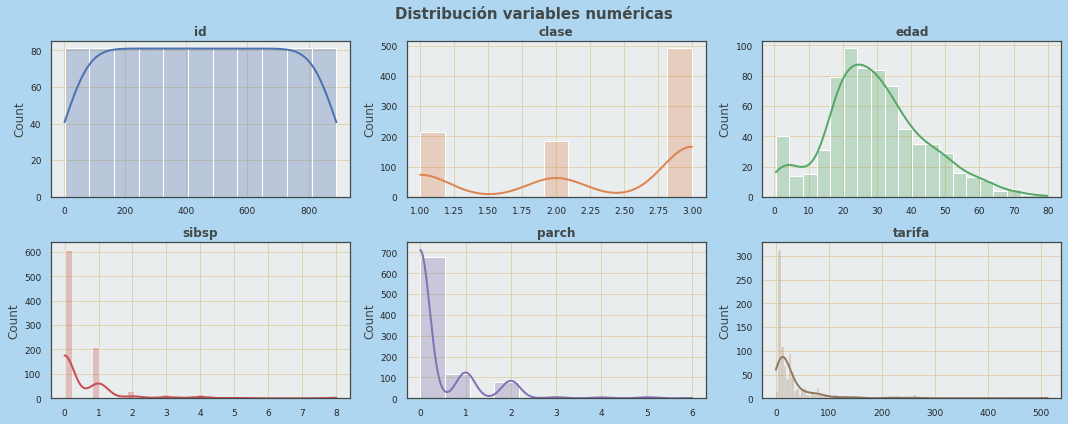

In [20]:
# Gráfico de distribución para cada variable numérica
# ==============================================================================
# Ajustar número de subplots en función del número de columnas
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 6))
axes = axes.flat
columnas_numeric = train.select_dtypes(include=['float64', 'int']).columns
columnas_numeric = columnas_numeric.drop('vida')

for i, colum in enumerate(columnas_numeric):
    sns.histplot(
        data    = train,
        x       = colum,
        stat    = "count",
        kde     = True,
        color   = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],
        line_kws= {'linewidth': 2},
        alpha   = 0.3,
        ax      = axes[i]
    )
    axes[i].set_title(colum, fontsize = 12, fontweight = "bold")
    axes[i].tick_params(labelsize = 9)
    axes[i].set_xlabel("")
    
    
fig.tight_layout()
plt.subplots_adjust(top = 0.9)
fig.suptitle('Distribución variables numéricas', fontsize = 15, fontweight = "bold");

<b>Aunque algunas variables contienen valores numéricos, realmente son variables categóricas. Además procedo a eliminar la variable <b>"id"</b>, la cual hace referencia al número de indentificación de los pasajeros.

### <b> Edad

Esta variable contiene 177 observaciones faltantes.

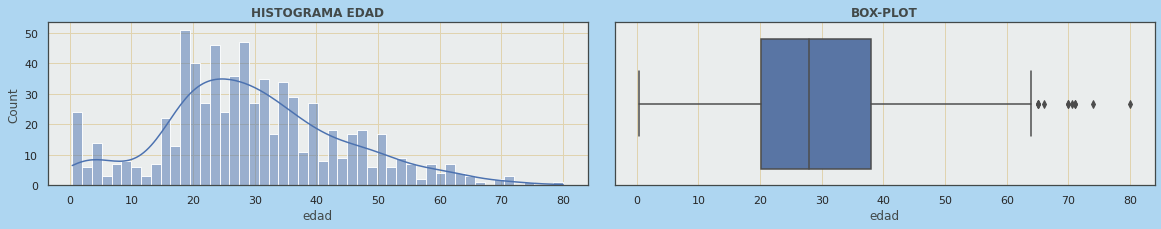

In [21]:
# Gráficas de distribución para la variable edad
# ==============================================================================
fig = plt.figure(figsize=(30,3))
gs = fig.add_gridspec(1,3)

ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])

ax0.set_title("HISTOGRAMA EDAD", fontweight='bold')
ax1.set_title("BOX-PLOT", fontweight='bold')

sns.histplot(x=train.edad , bins=50, kde=True, ax=ax0)
sns.boxplot(x=train.edad, ax=ax1)
fig.subplots_adjust(wspace=0.05)
plt.show()

In [23]:
# Pruebas de normalidad 
# ==============================================================================
mask = train['edad'].dropna() # 'edad' sin incluir los valores faltantes

# Shapiro-Wilk
shapiro = stats.shapiro(mask)
#K^2 D'Agostino
dagostino = stats.normaltest(mask)
print(shapiro)
print(dagostino)

ShapiroResult(statistic=0.9814548492431641, pvalue=7.322165629375377e-08)
NormaltestResult(statistic=18.105032952089758, pvalue=0.00011709599657350757)


<div style="color:#9A7D0A;
           display:fill;
           padding: 5px;
           border-radius:10px;
           border-style: solid;
           border-color: #F9E79F;
           background-color:#FCF3CF;
           font-size:15px;
           font-family: Didot;
           letter-spacing:0.5px">
    <b>📝 Note:</b> Las pruebas de normalidad (Shapiro-Wilk y K^2 D'Agostino), nos indica que hay evidencias significativas de que la variable <b>edad</b> no se distribuye de manera normal.
</div>

<b>Prueba de hipótesis</b> para comprobar si hay diferencia entre las distribuciones de <b>edad</b>, entre los pasajeros que sobrevivieron y los que fallecieron.  

In [24]:
# Creación de grupos (vivos - muertos)
edad_vida_0 = train[train['vida']==0]['edad'].dropna() # Fallecidos
edad_vida_1 = train[train['vida']==1]['edad'].dropna() # Sobrevivientes

# Mann-Withney U test
# ===============================================================================
mannwhitneyu = stats.mannwhitneyu(edad_vida_0, edad_vida_1)
# Kruskal-Wallis test
# ===============================================================================
kruskalwallis = stats.kruskal(edad_vida_0, edad_vida_1)
print(mannwhitneyu)
print(kruskalwallis)

MannwhitneyuResult(statistic=65278.0, pvalue=0.16049252477737763)
KruskalResult(statistic=1.970097978146391, pvalue=0.16043746252207006)


Al igual que la puntuación de <b>mutual information</b> lo sugiere; mediante las pruebas de hipótesis no paramétricas <b>Mann-Withney U</b> y <b>Kruskal-Wallis</b> podemos concluir que la <b>edad</b> no es predictora de supervivencia. Mediante ambas hipótesis se encontró que no hay evidencias significativas de que haya difrencias entre la <b>edad</b> del grupo de supervivientes en contraste no el grupo de fallecidos. Elimino esta variable

In [25]:
train.drop('edad', axis=1, inplace=True)
test.drop('edad', axis=1, inplace=True)

### <b>Tarifa

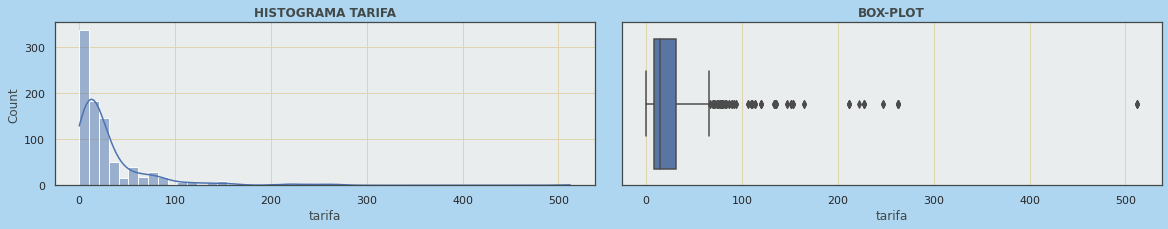

In [29]:
# Gráficas de distribución para la variable tarifa
# ==============================================================================
fig = plt.figure(figsize=(30,3))
gs = fig.add_gridspec(1,3)

ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])

ax0.set_title("HISTOGRAMA TARIFA", fontweight='bold')
ax1.set_title("BOX-PLOT", fontweight='bold')

sns.histplot(x=train.tarifa , bins=50, kde=True, ax=ax0)
sns.boxplot(x=train.tarifa, ax=ax1)
fig.subplots_adjust(wspace=0.05)
plt.show()

Se puede observar que <b>tarifa</b> tiene una distribución asimetrica y contiene gran cantidad de valores atípicos.

## <b>VARIABLES CUALITATIVAS

## *****************************************************************************

In [31]:
train = train.copy()
test = test.copy()

In [26]:
# Transformando variables a categóricas
for col in ['parch','clase','sibsp']:
    train[col] = train[col].astype('object')

In [30]:
# Variables cualitativas (tipo object)
# ==============================================================================
train.select_dtypes(include=['object']).describe()

,sexo,ticket,puerto
count,891,891,889
unique,2,681,3
top,male,347082,S
freq,577,7,644


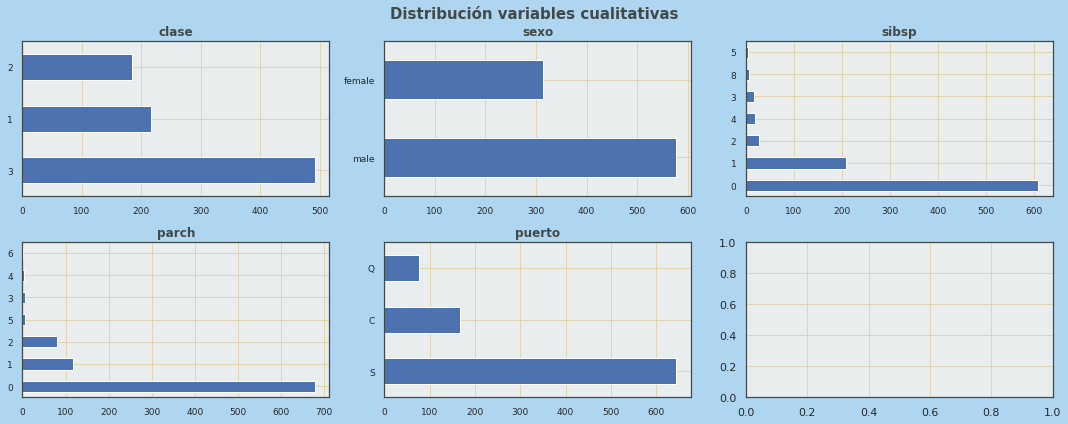

In [28]:
# Gráfico para cada variable cualitativa
# ==============================================================================

mask = train.drop(['ticket'], axis=1)

# Ajustar número de subplots en función del número de columnas
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 6))
axes = axes.flat
columnas_object = mask.select_dtypes(include=['object']).columns

for i, colum in enumerate(columnas_object):
    mask[colum].value_counts().plot.barh(ax = axes[i])
    axes[i].set_title(colum, fontsize = 12, fontweight = "bold")
    axes[i].tick_params(labelsize = 9)
    axes[i].set_xlabel("")
 
fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Distribución variables cualitativas',
             fontsize = 15, fontweight = "bold");

## <b>Ticket

In [33]:
train['ticket'].value_counts()

347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
           ..
9234        1
19988       1
2693        1
PC 17612    1
370376      1
Name: ticket, Length: 681, dtype: int64

## <b>Parch

Esta variable contiene observaciones que van desde 0 hasta el 6. En la que el valor 0: representa a los pasajeros que viajaron sin acompañantes; 1: acompañados por una persona; 2: acompañados por dos personas, y así sucesivamente.

In [35]:
# Cantidad por acompañantes en parch
train.parch.value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: parch, dtype: int64

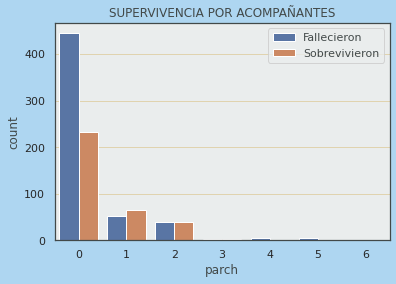

In [31]:
# Gráfica de supervivencia por acompañantes
plt.title("SUPERVIVENCIA POR ACOMPAÑANTES")
sns.countplot(x='parch', hue='vida', data=train)
plt.legend(['Fallecieron', 'Sobrevivieron'], loc='upper right')
plt.show()

<div style="color:#9A7D0A;
           display:fill;
           padding: 5px;
           border-radius:10px;
           border-style: solid;
           border-color: #F9E79F;
           background-color:#FCF3CF;
           font-size:15px;
           font-family: Didot;
           letter-spacing:0.5px">
<b>📝 Note:</b> Hay muy pocas observaciones de pasajeros que no viajaron solos.
</div>

<div style="color:#21618C;
           display:fill;
           padding: 5px;
           border-radius:10px;
           border-style: solid;
           border-color: #AED6F1;
           background-color:#D6EAF8;
           font-size:15px;
           font-family: Didot;
           letter-spacing:0.5px">
<b>💡 Idea:</b> Convertir las observaciones en valores binarios. Pasajeros que viajaron solos y pasajeros acompañados.
</div>

## <b> Clase



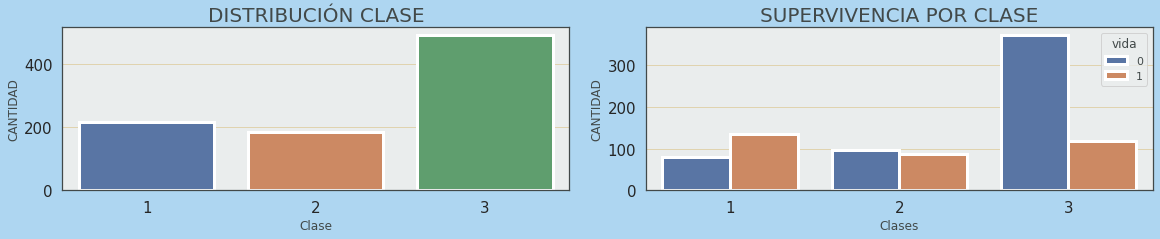

In [37]:
# Visualización de distribución de clases
fig = plt.figure(figsize=(30,3))

# add grid to figure
gs = fig.add_gridspec(1,3)

# fill grid with subplots
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])

# adjust subheadline fontsize
ax0.set_title("DISTRIBUCIÓN CLASE", fontsize=20)
ax1.set_title("SUPERVIVENCIA POR CLASE", fontsize=20)

# adjust lable fontsize
ax0.tick_params(labelsize=15)
ax1.tick_params(labelsize=15)

# plot data into subplots 
sns.countplot(x="clase",data=train, ax=ax0, linewidth = 3).set(xlabel="Clase", ylabel="CANTIDAD")
sns.countplot(x="clase",data=train, ax=ax1, linewidth = 3, hue="vida").set(xlabel="Clases",ylabel="CANTIDAD")
fig.subplots_adjust(wspace=0.15)
plt.show()

<div style="color:#9A7D0A;
           display:fill;
           padding: 5px;
           border-radius:10px;
           border-style: solid;
           border-color: #F9E79F;
           background-color:#FCF3CF;
           font-size:15px;
           font-family: Didot;
           letter-spacing:0.5px">
<b>📝 Note:</b> La mayoría de los pasajeros abordo viajaron en tercera clase, seguido por los de primera clase y segunda clase.
</div>

<div style="color:#9A7D0A;
           display:fill;
           padding: 5px;
           border-radius:10px;
           border-style: solid;
           border-color: #F9E79F;
           background-color:#FCF3CF;
           font-size:15px;
           font-family: Didot;
           letter-spacing:0.5px">
<b>📝 Note:</b> La primera clase fue la única que registró un porcentaje de sobrevivientes mayor que de fallecidos, sin embargo, es notable la gran proporción de fallecidos que viajaron en tercera clase. Esta parece ser una variable de peso para inferir si un pasajero abordo sebrevivió o no.  
</div>

<b> 

## <b>Sexo

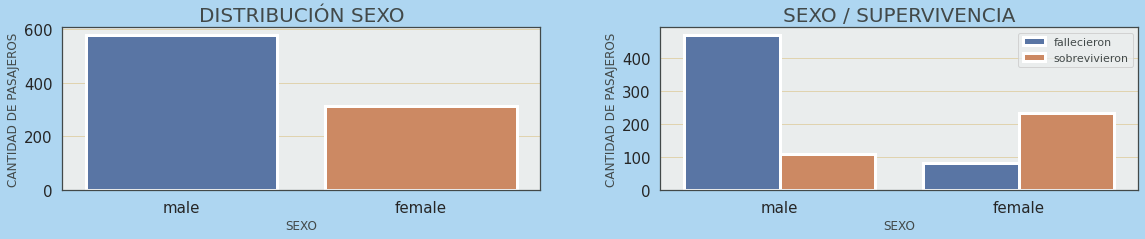

In [39]:
# Visualización de distribución de sexo
# build figure
fig = plt.figure(figsize=(30,3))

# add grid to figure
gs = fig.add_gridspec(1,3)

# fill grid with subplots
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])

# adjust subheadline fontsize
ax0.set_title("DISTRIBUCIÓN SEXO", fontsize=20)
ax1.set_title("SEXO / SUPERVIVENCIA", fontsize=20)

# adjust lable fontsize
ax0.tick_params(labelsize=15)
ax1.tick_params(labelsize=15)

# plot data into subplots 
sns.countplot(x="sexo",data=train, ax=ax0, linewidth = 3).set(xlabel="SEXO", ylabel="CANTIDAD DE PASAJEROS")
sns.countplot(x="sexo",data=train, ax=ax1, linewidth = 3, hue="vida").set(xlabel="SEXO", ylabel="CANTIDAD DE PASAJEROS")
plt.legend(["fallecieron", "sobrevivieron"])
fig.subplots_adjust(wspace=0.25)
plt.show()

In [40]:
# Porcentaje de supervivientes por sexo.
hombres_df = train[train['sexo']=='male']['vida']
mujeres_df = train[train['sexo']=='female']['vida']

print('El '+ str(round(len(hombres_df[hombres_df==1])*100/len(hombres_df),2)) +'% de los hombres sobrevivió.')
print('El '+ str(round(len(mujeres_df[mujeres_df==1])*100/len(mujeres_df),2)) +'% de los mujeres sobrevivió.')

El 18.89% de los hombres sobrevivió.
El 74.2% de los mujeres sobrevivió.


<div style="color:#9A7D0A;
           display:fill;
           padding: 5px;
           border-radius:10px;
           border-style: solid;
           border-color: #F9E79F;
           background-color:#FCF3CF;
           font-size:15px;
           font-family: Didot;
           letter-spacing:0.5px">
<b>💡 Idea:</b> Claramente se puede observar que gran porcentaje de las feminas sobrevivió (74%), en contraste, el porcentaje de los masculinos sobrevivientes fue muy bajo (19%).
</div>

## <b>Clase vs Sexo

In [41]:
f_clase = train[train['sexo']=='female'][['clase', 'vida']]
m_clase = train[train['sexo']=='male'][['clase', 'vida']]

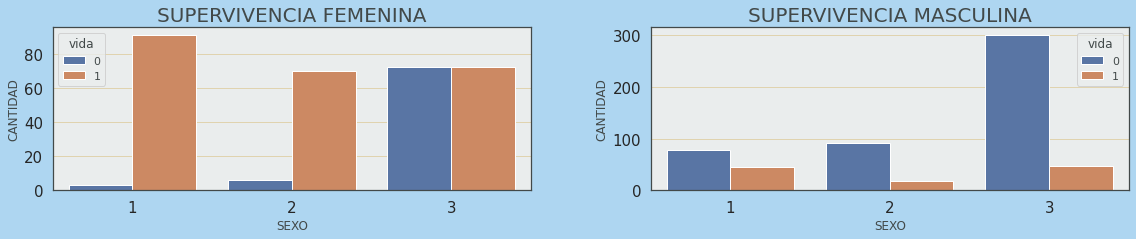

In [42]:
# Visualización de distribución de sexo
# build figure
fig = plt.figure(figsize=(30,3))

# add grid to figure
gs = fig.add_gridspec(1,3)

# fill grid with subplots
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])

# adjust subheadline fontsize
ax0.set_title("SUPERVIVENCIA FEMENINA", fontsize=20)
ax1.set_title("SUPERVIVENCIA MASCULINA", fontsize=20)

# adjust lable fontsize
ax0.tick_params(labelsize=15)
ax1.tick_params(labelsize=15)

# plot data into subplots 
sns.countplot(x='clase', hue='vida', data=f_clase, ax=ax0).set(xlabel="SEXO", ylabel="CANTIDAD")
sns.countplot(x='clase', hue='vida', data=m_clase, ax=ax1).set(xlabel="SEXO", ylabel="CANTIDAD")
fig.subplots_adjust(wspace=0.25)
plt.show()

In [43]:
# Unión de las variables sexo y clase
# ===========================================================================
train['clase_sexo'] = train['sexo'].map(str) +'_'+ train['clase'].map(str)
test['clase_sexo'] = test['sexo'].map(str) +'_'+ test['clase'].map(str)

# Eliminación de variables
# ===========================================================================
train.drop(['clase', 'sexo'], axis=1, inplace=True)
test.drop(['clase', 'sexo'], axis=1, inplace=True)

# <b>Puerto

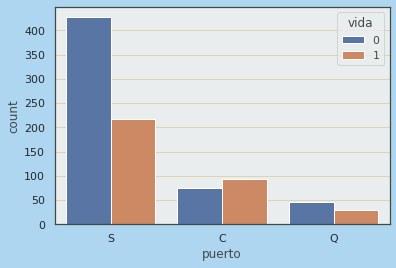

In [44]:
sns.countplot(x=train.puerto, hue=train.vida)
plt.show()

<AxesSubplot:xlabel='puerto', ylabel='count'>

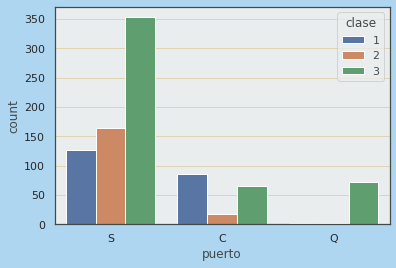

In [42]:
sns.countplot(x='puerto', hue='clase', data=df_train)
plt.show()

# <b>PREPARE DATA

<b>Sólo utilizaré tres variables 3 variables como predictores.

In [45]:
# Conjunto de datos de entrenamiento
X_train = train[['ticket', 'clase_sexo', 'tarifa']]
y_train = train.vida

# Conjunto de datos de prueba
X_test = test[['ticket', 'clase_sexo', 'tarifa']]

In [46]:
num_features = X_train.select_dtypes(exclude='object').columns
cat_features = X_train.select_dtypes(include='object').columns

### <b>TRANSFORMADOR

In [76]:
# Transformación de predictores
# =============================================================================

# numerical transformer pipeline (only contains 'tarifa')
num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ("scaler", RobustScaler()),
                           ])

# categorical transformer pipeline
cat_transformer = Pipeline([ 
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore')),
                            ])

transformer = ColumnTransformer([
    ('num_transfomer', num_transformer, num_features),
    ('cat_transformer', cat_transformer, cat_features),
                                ],remainder='passthrough')

X_prepared = transformer.fit_transform(X_train)

### <b>SELECCIÓN DE MODELO

In [48]:
# Búsqueda del modelo con mejor puntaje
# ===================================================================================

models = {'svc': SVC(), 
          'logistic': LogisticRegression(),
          'random_forest': RandomForestClassifier(),
          'knn': KNeighborsClassifier()}

n_models = len(models)
scores=[]
for name, model in models.items():
    y_train_pred = cross_val_predict(model, X_prepared, y_train, cv=10)
    precision = np.mean(precision_score(y_train, y_train_pred)).round(2)
    recall = np.mean(recall_score(y_train, y_train_pred)).round(2)
    f1 = np.mean(f1_score(y_train, y_train_pred)).round(2)

    model_scores = np.array([name, precision, recall, f1])
    scores.append(np.array(model_scores))
          
scores_df = pd.DataFrame(scores, columns=['Model', 'Precision', 'Recall', 'F1']); scores_df.set_index('Model', inplace=True)
scores_df.sort_values(by='F1', ascending=False)

,Precision,Recall,F1
Model,,,
random_forest,0.86,0.68,0.76
svc,0.8,0.69,0.74
knn,0.75,0.7,0.73
logistic,0.85,0.63,0.72


In [49]:
# Reporte de puntuaciones del modelo Random Forest
# ==============================================================================
rforest_clf = RandomForestClassifier(random_state=42)
y_pred = cross_val_predict(rforest_clf, X_prepared, y_train)
print(confusion_matrix(y_train, y_pred))
print(classification_report(y_train, y_pred))

[[507  42]
 [117 225]]
              precision    recall  f1-score   support

           0       0.81      0.92      0.86       549
           1       0.84      0.66      0.74       342

    accuracy                           0.82       891
   macro avg       0.83      0.79      0.80       891
weighted avg       0.82      0.82      0.82       891



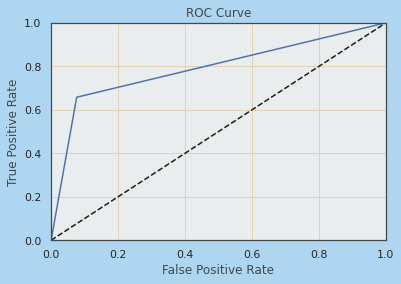

In [50]:
# Área bajo la curva
# ================================================================================

y_scores = cross_val_predict(rforest_clf, X_prepared, y_train, cv=5, n_jobs=-1)
threshold = 0.5
y_with_thres = (y_scores > threshold)
fpr, tpr, thresholds = roc_curve(y_train, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, label=label)
    plt.plot([0, 1], [0,1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
plot_roc_curve(fpr, tpr)
plt.show()

In [51]:
# Puntaje del area bajo la curva
# ============================================================================================
roc_auc_score(y_train, y_pred)

0.7906960023008341

### <b>CONSTRUCCIÓN DEL MODELO (RANDOM FOREST)

In [52]:
# Valores para hiperparámetros
# ===================================================================
# Cantidad de árboles
n_estimators = [int(x) for x in np.linspace(start=10, stop=500)]
# Cantidad de características a considerar en cada split
max_features = ['auto', 'sqrt', None]
# Máximo de niveles por árbol
max_depth = [int(x) for x in np.linspace(5, 50, num=45)]
max_depth.append(None)
# Mínimas muestras requeridad para dividir un nodo
min_samples_split = [2, 4, 6, 8, 10]
# Cantidad de muestras requeridas para cada hoja de nodo
min_samples_leaf = [1, 2, 4, 8, 10, 12, 14, 16, 20, 25, 30]
# Método de selección de muestras para entrenamiento en cada árbol
bootstrap = [True]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [54]:
# Búsqueda aleatoria de hiperparámetros - RandomizedSearchCV
# ==============================================================================
rforest_classifier = RandomForestClassifier(random_state=23)
rf_random = RandomizedSearchCV(estimator=rforest_classifier, param_distributions=random_grid, n_iter=100, scoring='f1',
                               cv=3, random_state=123, n_jobs=-1,
                               return_train_score=False)

rf_random.fit(X_prepared, y_train)

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=23),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True],
                                        'max_depth': [5, 6, 7, 8, 9, 10, 11, 12,
                                                      13, 14, 15, 16, 17, 18,
                                                      19, 20, 21, 22, 23, 24,
                                                      25, 26, 27, 28, 29, 30,
                                                      31, 32, 33, 34, ...],
                                        'max_features': ['auto', 'sqrt', None],
                                        'min_samples_leaf': [1, 2, 4, 8, 10, 12,
                                                             14, 16, 20, 25,
                                                             30],
                                        'min_samples_split': [2, 4, 6, 8, 10],
                                        'n_esti

In [55]:
# Mejores hiperparámetros aleatorios
# ==============================================================================
rf_random.best_params_

{'n_estimators': 230,
 'min_samples_split': 8,
 'min_samples_leaf': 1,
 'max_features': None,
 'max_depth': 45,
 'bootstrap': True}

In [56]:
# Resultados de predicción del modelo con los mejores hiperparámetros aleatorios.
# ==============================================================================
rf_random = rf_random.best_estimator_
rf_random_pred = cross_val_predict(rf_random, X_prepared, y_train, cv=10, n_jobs=-1)
confusion_matrix(y_train, rf_random_pred)

array([[505,  44],
       [108, 234]])

In [57]:
# Reporte de puntuaciones del modelo con los mejores hiperparámetros aleatorios.
# ==============================================================================
print(classification_report(y_train, rf_random_pred))

              precision    recall  f1-score   support

           0       0.82      0.92      0.87       549
           1       0.84      0.68      0.75       342

    accuracy                           0.83       891
   macro avg       0.83      0.80      0.81       891
weighted avg       0.83      0.83      0.83       891



<div style="color:#9A7D0A;
           display:fill;
           padding: 5px;
           border-radius:10px;
           border-style: solid;
           border-color: #F9E79F;
           background-color:#FCF3CF;
           font-size:15px;
           font-family: Didot;
           letter-spacing:0.5px">
    <b>📝 Note:</b> Utilizando <b>F1-score</b> como métrica para evaluar el rendimiento del modelo, se puede apreciar un muy ligero incremento en la puntuación. 0.01 <b>(0.87)</b> para clase 0 y 0.01 <b>(0.75)</b> para clase 1.
</div>

#### <b>param_grid 

<b> Tomando como referencia los mejores parámetros arrojados por <b>RandomizedGridCV</b>, busco muevos parámetros que puedan mejor la precisión del modelo.

In [58]:
param_grid = {
    'n_estimators': [200, 210, 220, 230, 240],
    'min_samples_split': [7, 8, 9],
    'min_samples_leaf': [1, 2, 3],
    'max_features': [None],
    'max_depth': [40, 45, 55, 60],
    'bootstrap': [True]
}

rforest_classifier2 = RandomForestClassifier(random_state=65)
grid_search = GridSearchCV(estimator=rforest_classifier2, param_grid =param_grid,
                           cv=3, n_jobs=-1, scoring='f1',
                           return_train_score=False)

grid_search.fit(X_prepared, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=65), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [40, 45, 55, 60],
                         'max_features': [None], 'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [7, 8, 9],
                         'n_estimators': [200, 210, 220, 230, 240]},
             scoring='f1')

In [59]:
# Mejores parámetros con GridSearch
# ==============================================================================
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 40,
 'max_features': None,
 'min_samples_leaf': 1,
 'min_samples_split': 7,
 'n_estimators': 210}

In [60]:
# Resultados de predicción del modelo con los mejores parámetros GridSearchCV
# ==============================================================================
grid_search_model = grid_search.best_estimator_
grid_pred = cross_val_predict(grid_search_model, X_prepared, y_train, cv=10, n_jobs=-1)
confusion_matrix(y_train, grid_pred)

array([[505,  44],
       [107, 235]])

In [62]:
# Reporte de puntuaciones del modelo Random Forest utilizando GridSearchCV
# ==============================================================================
print(classification_report(y_train, grid_pred))

              precision    recall  f1-score   support

           0       0.83      0.92      0.87       549
           1       0.84      0.69      0.76       342

    accuracy                           0.83       891
   macro avg       0.83      0.80      0.81       891
weighted avg       0.83      0.83      0.83       891



Hubo una pequeña mejora para la clasificación de la clase 1 en un 0.01 (0.76) con el modelo <b>grid_model</b>.

In [64]:
# Última búsqueda de parámetros
# ================================================================================
param_grid2 = {'bootstrap': [True],
 'max_depth': [38, 40, 42],
 'max_features': [None],
 'min_samples_leaf': [1],
 'min_samples_split': [7],
 'n_estimators': [205, 210, 215]}

rforest_classifier3 = RandomForestClassifier(random_state=12)
grid_search2 = GridSearchCV(estimator=rforest_classifier3, param_grid =param_grid2,
                           cv=3, n_jobs=-1, scoring='f1',
                           return_train_score=False)

grid_search2.fit(X_prepared, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=12), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [38, 40, 42],
                         'max_features': [None], 'min_samples_leaf': [1],
                         'min_samples_split': [7],
                         'n_estimators': [205, 210, 215]},
             scoring='f1')

In [66]:
grid_search2.best_params_

{'bootstrap': True,
 'max_depth': 38,
 'max_features': None,
 'min_samples_leaf': 1,
 'min_samples_split': 7,
 'n_estimators': 210}

In [67]:
# Resultados de predicción del modelo con los mejores parámetros GridSearchCV
# ==============================================================================
grid_search_model2 = grid_search2.best_estimator_
grid_pred2 = cross_val_predict(grid_search_model2, X_prepared, y_train, cv=10, n_jobs=-1)
confusion_matrix(y_train, grid_pred2)

array([[505,  44],
       [107, 235]])

In [68]:
# Reporte de puntuaciones del modelo Random Forest utilizando GridSearchCV
# ==============================================================================
print(classification_report(y_train, grid_pred2))

              precision    recall  f1-score   support

           0       0.83      0.92      0.87       549
           1       0.84      0.69      0.76       342

    accuracy                           0.83       891
   macro avg       0.83      0.80      0.81       891
weighted avg       0.83      0.83      0.83       891



No hubo mejoras en la capacidad de predicción sobre el modelo anterior. Tomo este como modelo final.

In [69]:
final_model = grid_search_model2

# <b>PREDICCIÓN

In [77]:
# Transformación de los predictores en el conjunto de datos de prueba
test_prepared = transformer.transform(X_test)

In [78]:
# Predicciones
# ====================================================================================
predictions = final_model.predict(test_prepared)

In [96]:
test['vida'] = predictions
titanic_preds = test[['id', 'vida']]
titanic_preds.columns=['PassengerId', 'Survived']
titanic_preds.to_csv('submission2.csv',index=False)

In [93]:
# Resultados de predicciones
# =====================================================================================
titanic_preds

,Survived
PassengerId,
892,0
893,1
894,0
895,0
896,1
...,...
1305,0
1306,1
1307,0
